# Using Neural Network for Toxic Comment Analysis

## Step 1: Data Cleaning

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("../scripts")
import data_cleaning

In [3]:
# Load the data
data = pd.read_csv('../data/train.csv')

In [4]:
# Clean the data
data = data_cleaning.clean_data(data)

In [5]:
# Print data attributes
print(f"Number of rows: {data.shape[0]}")
print(f"Number of columns: {data.shape[1]}")

# Count NA Comments
num_na_comments = data['comment_text'].isna().sum()
print(f"Number of NA comments: {num_na_comments}")

# Count NA Values
num_na_values = data['comment_text'].isna().sum().sum()
print(f"Number of NA values: {num_na_values}")

# Count duplicates
duplicates = data.duplicated().sum()
print(f"Number of duplicates: {duplicates}")

Number of rows: 1593228
Number of columns: 15
Number of NA comments: 0
Number of NA values: 0
Number of duplicates: 0


In [6]:
data["rating_rejected"] = data["rating_rejected"].astype(int)
#False to 0 and True to 1

In [7]:
data.head(10)

,comment_text,funny,wow,sad,likes,disagree,toxicity,severe_toxicity,obscene,sexual_explicit,identity_attack,insult,threat,toxicity_annotator_count,rating_rejected
0,That was the reason Walker fire everyone now w...,0,0,0,0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,4,0
1,So my original statement still stands . A chur...,0,0,0,2,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,4,0
2,All you ever do is come to these forums berati...,0,0,0,0,0,0.714286,0.014286,0.171429,0.0,0.300000,0.671429,0.0,70,1
3,Tonight will be an excellent opportunity for C...,0,0,0,0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,4,0
4,I read about this on Stars and Stripes oversea...,0,0,0,1,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,4,0
5,No one is willing to build an upgrader or refi...,0,1,0,14,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,4,0
6,This is one of Canada's priority during the ne...,1,0,0,2,2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,4,0
7,I do not think one can refer to this killer as...,0,0,0,1,1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,4,0
8,Past behavior is the best prediction of future...,0,0,0,0,0,0.300000,0.000000,0.000000,0.0,0.000000,0.300000,0.0,10,0
9,"""he worked as a mail carrier and an IRS agent ...",0,0,0,0,0,0.166667,0.000000,0.166667,0.0,0.166667,0.000000,0.0,6,0


## Step 2: Sentiment Analysis Exploration

In [21]:
data["rating_rejected"].value_counts(normalize=True)
#There are much more comments that are approved than rejected.


rating_rejected
0    0.934247
1    0.065753
Name: proportion, dtype: float64

array([[<Axes: title={'center': 'word_length'}>,
        <Axes: title={'center': 'char_length'}>]], dtype=object)

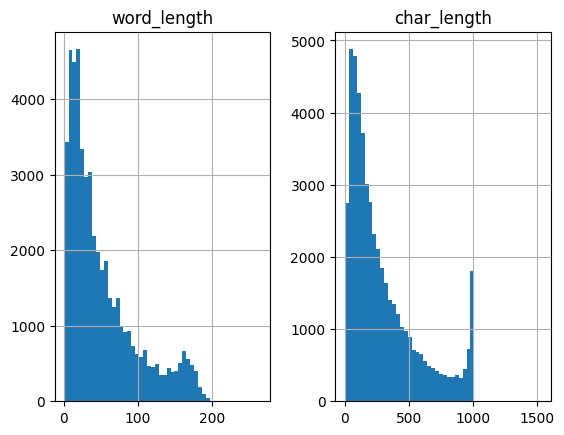

In [14]:
data_eda = data.sample(n=50000, random_state=42)
data_eda["word_length"] = data_eda["comment_text"].str.split().str.len()
data_eda["char_length"] = data_eda["comment_text"].str.len()
data_eda[["word_length", "char_length"]].hist(bins=50)


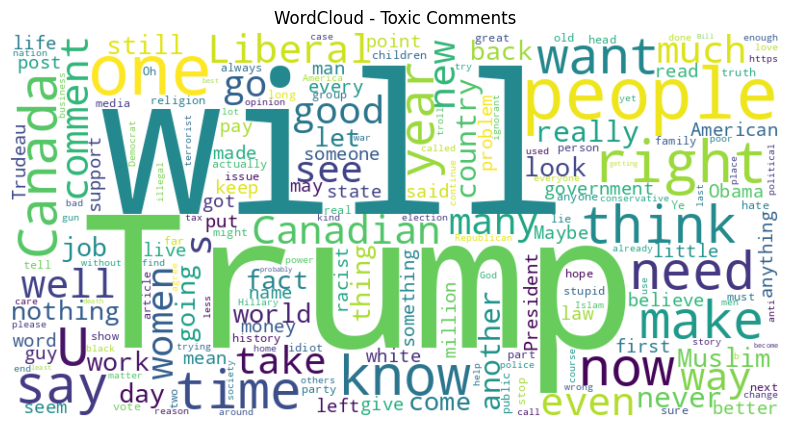

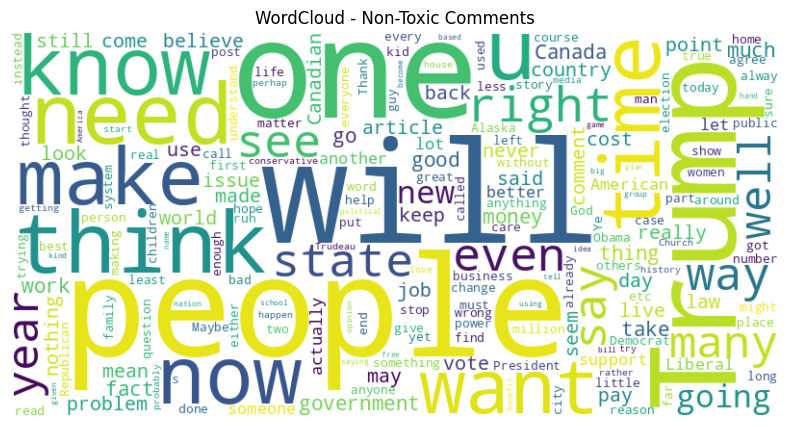

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

toxic_comments = " ".join(data_eda[data_eda["rating_rejected"] == 1]["comment_text"].astype(str))
nontoxic_comments = " ".join(data_eda[data_eda["rating_rejected"] == 0]["comment_text"].astype(str))

# Wordcloud for toxic comments
toxic_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(toxic_comments)

plt.figure(figsize=(10, 5))
plt.imshow(toxic_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Toxic Comments")
plt.show()

# Wordcloud for non-toxic comments
nontoxic_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(nontoxic_comments)

plt.figure(figsize=(10, 5))
plt.imshow(nontoxic_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Non-Toxic Comments")
plt.show()


In [18]:
data_eda.groupby("rating_rejected")["toxicity"].mean()


rating_rejected
0    0.091047
1    0.263437
Name: toxicity, dtype: float64

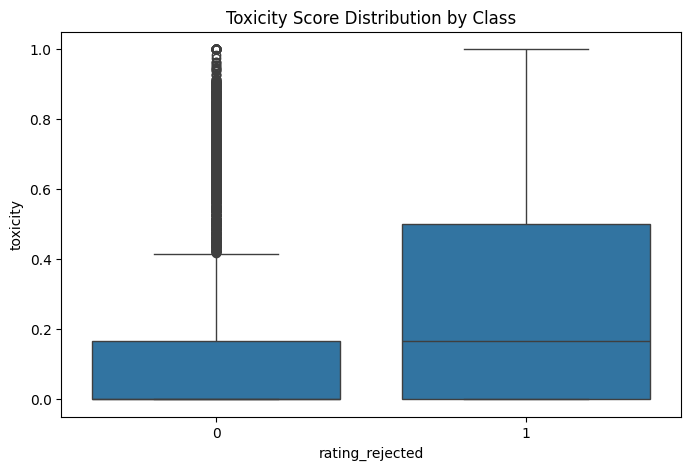

In [20]:
import seaborn as sns
plt.figure(figsize = (8, 5))
sns.boxplot(x = "rating_rejected", y = "toxicity", data = data_eda)
plt.title("Toxicity Score Distribution by Class")
plt.show()

* For the non-toxic comments, the median toxicity score is very low. The box is small, meaning that most non-toxic comments have consistently low toxicity. However, there are many outliers above 0.4, meaning that some comments are considered "non-toxic" with moderate to high toxicity scores.
* For the toxic comments, the median toxicity score is much higher than the non-toxic comments. The box is also much taller meaning that toxic comments vary - some are mildly toxic and some are extremely toxic. The whiskers reach near 1.0 meaning many comments get max toxicity scores.

The whisker for non-toxic comments extends up to a toxicity score of ~0.4. This indicates that many comments labeled ‘non-toxic’ still contain mild or borderline toxic language. This reflects annotator disagreement and noise around lower toxicity levels, which contributes to overlap between classes. As a result, classification models must handle ambiguous cases where continuous toxicity scores suggest some toxicity even though the binary label is 0.

## 3. Models Optimization and Training

In [22]:
X = data.drop(columns = ["rating_rejected"])
y = data["rating_rejected"]